# StreamMultiDiffusion Streaming Pipeline Demo

For additional info, please consult our paper: *StreamMultiDiffusion: Real-Time Interactive Generation with Region-Based Semantic Control*. Especially the appendices for the usage of this application.

## Preparation

In [1]:
seed = 2024
device = 5

[INFO] Initialized with seed  : 2024
[INFO] Initialized with device: cuda:5
[INFO] Loading masks...


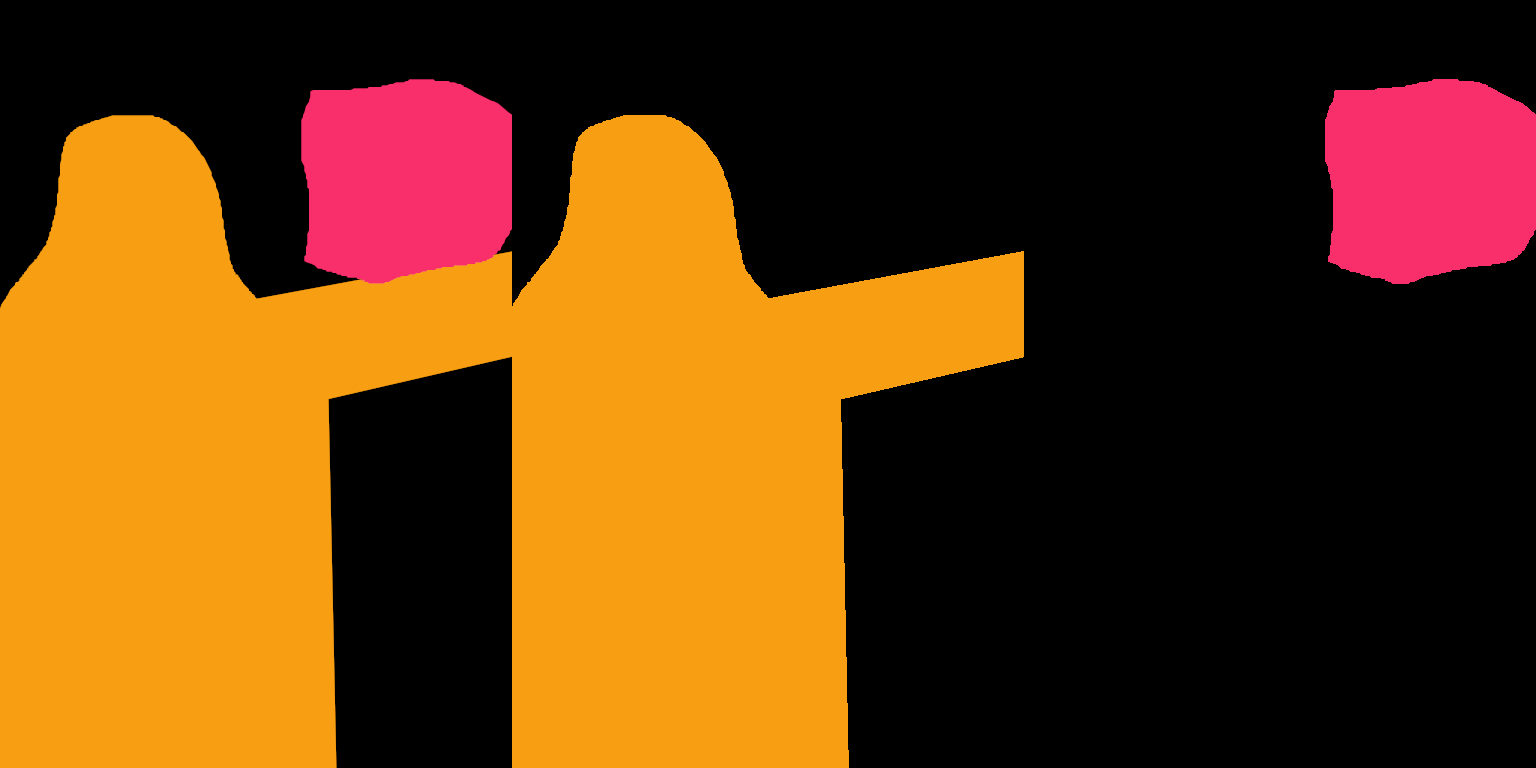

In [2]:
import sys
import time
import warnings

sys.path.append('../src')
warnings.filterwarnings('ignore')

import torch
import torchvision.transforms as T
from PIL import Image
from diffusers.utils import make_image_grid
from IPython.display import clear_output

from util import seed_everything, Streamer
from model import StreamMultiDiffusion


device = f'cuda:{device}'
seed_everything(seed)
print(f'[INFO] Initialized with seed  : {seed}')
print(f'[INFO] Initialized with device: {device}')

print('[INFO] Loading masks...') 
mask_all = Image.open('../assets/zeus/prompt.png').convert('RGBA')
mask_p1 = Image.open('../assets/zeus/prompt_p1.png').convert('RGBA')
mask_p2 = Image.open('../assets/zeus/prompt_p2.png').convert('RGBA')

mask_p1_t = T.ToTensor()(mask_p1)[-1:]
mask_p2_t = T.ToTensor()(mask_p2)[-1:]
background_t = torch.logical_and(mask_p1_t == 0, mask_p2_t == 0)

height, width = mask_p1_t.shape[-2:]
display(make_image_grid([mask_all, mask_p1, mask_p2], 1, 3))

# Run

## Step 1: Load a StreamMultiDiffusion pipeline.

In [3]:
streamer = StreamMultiDiffusion(
    device,
    sd_version='1.5',
    height=height,
    width=width,
    cfg_type="none",
    autoflush=True,
    use_tiny_vae=False,
    mask_type='continuous',
    bootstrap_steps=2,
    bootstrap_mix_steps=1.5,
    seed=seed,
)

[INFO]     Loading Stable Diffusion...


Loading pipeline components...: 100%|████████████████████████| 7/7 [00:01<00:00,  4.57it/s]


[INFO]     Model is loaded!
[INFO]     Parameters prepared!


## Step 2: Register background image (white image is OK).

In [4]:
streamer.update_background(Image.new(size=(width, height), mode='RGB', color=(255, 255, 255)))

True

## Step 3: Register *semantic palette*.

Semantic palette is a list of pairs (text prompt, mask), which we call a *semantic brush/layer*. This is a basic unit of drawing in the multiple region-based text-to-image synthesis.

In [5]:
streamer.update_single_layer(
    idx=0,
    prompt='a photo of Mount Olympus',
    negative_prompt='worst quality, bad quality, normal quality, cropped, framed',
    mask=background_t,
    mask_strength=1.0,
    mask_std=0.0,
    prompt_strength=1.0,
)
streamer.update_single_layer(
    idx=1,
    prompt='Greek god Zeus looking at viewer',
    negative_prompt='worst quality, bad quality, normal quality, cropped, framed',
    mask=mask_p1_t,
    mask_strength=1.0,
    mask_std=0.0,
    prompt_strength=1.0,
)
streamer.update_single_layer(
    idx=2,
    prompt='a small, sitting eagle',
    negative_prompt='worst quality, bad quality, normal quality, cropped, framed',
    mask=mask_p2_t,
    mask_strength=1.0,
    mask_std=0.0,
    prompt_strength=1.0,
)

## Step 4: Generate forever.

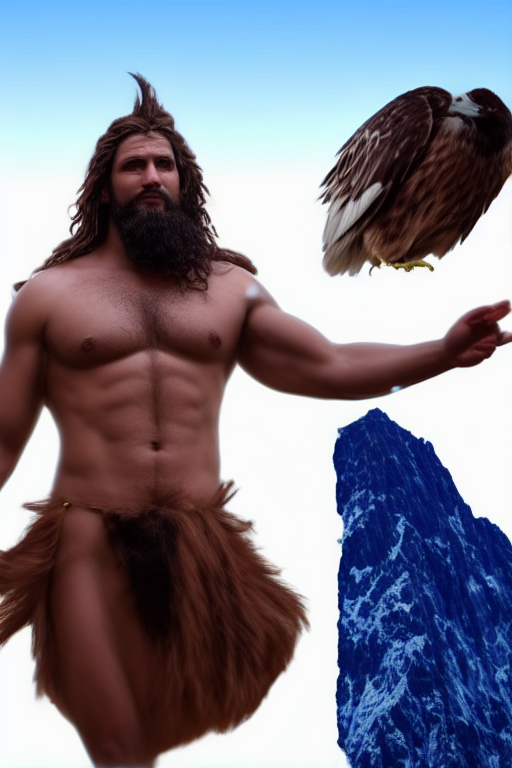

In [6]:
while True:
    display(streamer())
    time.sleep(0.2)
    clear_output()